# Question1 : Optimal Hedging Strategy !

stock_49 152
stock_271 72
stock_299 71


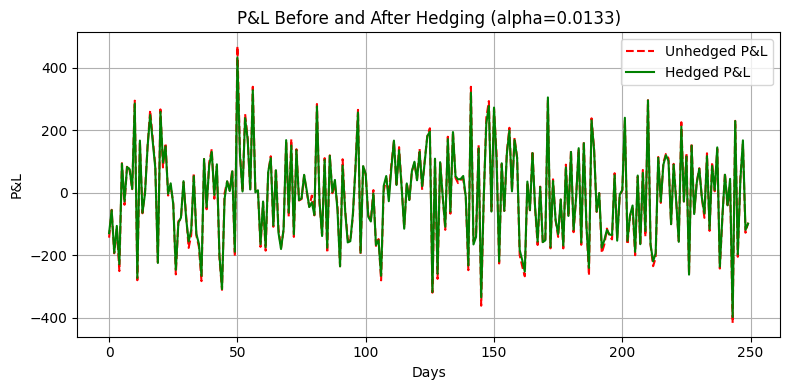

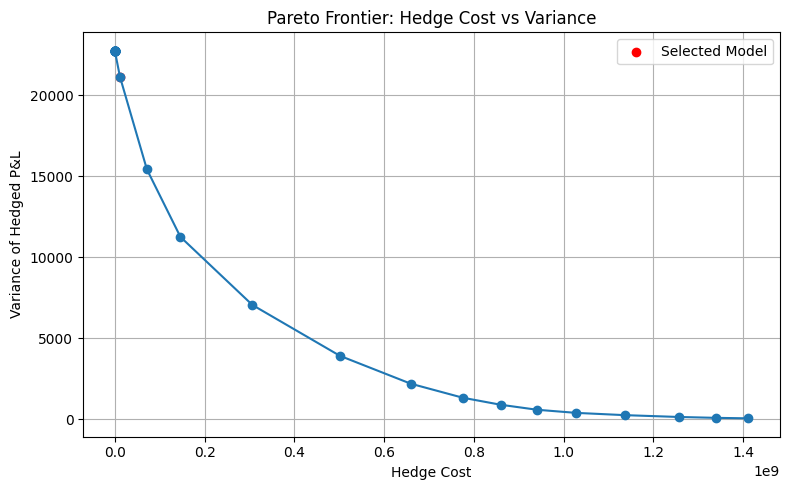

In [6]:
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV

def main():
    input_line = 'Portfolio_15 -143.947242 -54.696053 -194.050843 -114.379762 -250.914222 94.525127 -38.578749 87.924437 71.989914 11.229715 294.581902 -280.166856 164.614297 -65.917684 5.897927 150.181106 263.998383 174.068129 88.060921 -223.012161 266.605458 80.822122 158.287567 -9.023034 22.444253 -33.883753 -261.471284 -91.303422 -83.428574 33.292501 -73.951395 -176.659194 -135.428729 62.436845 -136.566712 -173.370305 -283.001479 107.665112 -53.090612 95.636076 139.235617 -19.10865 85.199601 -209.1056 -310.955306 -2.165499 35.976801 7.50174 73.062716 -203.179266 469.00358 127.236235 3.716109 252.211904 174.502566 6.919277 339.092547 4.422581 5.965394 -173.426425 -30.290419 -185.455906 65.674427 116.629944 -109.198075 78.179203 -115.110464 -177.391446 -119.218134 166.293029 -76.239738 171.411876 -141.504239 139.137473 -25.01957 -20.231675 55.088898 2.876409 -44.997561 -9.161336 -72.560697 283.933358 -34.321216 -135.798794 110.626876 -192.54237 119.526443 -1.670631 27.555595 -40.781872 -235.559946 107.050236 -56.895824 -147.281255 -156.770645 -75.445617 82.642868 265.12137 -196.013666 87.095452 56.390496 -72.333542 -88.827275 8.286346 -170.446357 -148.334462 -280.558408 4.362755 46.400015 -6.847279 91.234663 165.416968 20.210035 145.796151 22.934237 -112.741297 31.012431 -22.119119 68.527919 95.182339 42.33652 140.188056 9.100858 103.606242 180.677244 206.1336 -320.051696 107.214837 -275.824155 101.115325 -11.629589 -118.879814 179.147753 -67.162632 196.397848 47.642698 30.792682 41.573022 44.183258 -16.676944 -247.958614 339.049795 -155.912637 -138.184113 152.162531 -361.782844 -18.957799 239.77323 293.220672 -58.43556 269.09757 121.316655 -226.5609 91.962242 -58.319922 131.039805 207.790177 5.537777 176.764472 110.922365 -199.574635 -235.721358 -267.523291 33.088489 -56.281509 133.278441 -48.862124 -167.373615 19.464542 -160.257798 -149.425146 297.139127 -178.140481 42.800719 -88.711313 -141.499563 -22.497015 -178.339219 89.77678 -76.572525 135.606513 -126.414028 -13.139711 139.544421 -166.822281 164.313625 -98.407028 -264.842666 238.055878 139.604803 -61.628126 -1.396826 -193.065595 -165.36715 -114.776197 -140.0188 -149.45157 62.355782 -143.783067 -9.581666 7.968838 230.406302 -165.656265 -74.449799 -49.687282 -200.097204 51.320385 -169.522404 72.792048 -140.198797 296.193869 -166.100215 -235.234293 -208.255771 114.320455 -32.605264 96.040885 124.16604 109.84381 -100.553086 92.345497 -24.857538 -155.040899 225.620404 -27.926196 126.356083 -262.033456 158.129422 -64.263922 34.925883 78.358089 -16.682323 -80.531757 126.170745 -122.257938 97.482713 4.582632 140.674958 -242.783119 -79.575146 62.659014 -45.79654 30.429683 -416.711845 230.05549 -205.179518 46.296581 155.942441 -128.055691 -95.994111'
    parts = input_line.split()
    portfolio_id = parts[0]
    original_pnl = np.array(parts[1:], dtype=float)
    
    # Read metadata and returns
    metadata = pd.read_csv("/kaggle/input/q11111111111/stocks_metadata.csv")
    returns = pd.read_csv("/kaggle/input/q11111111111/stocks_returns.csv") / 100  # Convert percentage returns to decimals
    
    # Prepare stock data
    stock_ids = returns.columns[1:].tolist()  # Exclude 'date' column
    X = []
    capital_costs = []
    valid_stock_ids = []
    
    for stock_id in stock_ids:
        # Get capital cost from metadata
        meta_row = metadata[metadata['Stock_Id'] == stock_id]
        if meta_row.empty:
            continue
        capital_cost = meta_row['Capital_Cost'].values[0]
        if capital_cost <= 0:
            continue  # Skip if capital cost is non-positive (invalid)
        # Get returns for the stock
        stock_returns = returns[stock_id].values
        if len(stock_returns) != len(original_pnl):
            continue  # Ensure same number of days as the portfolio PnL
        # Scale returns by 1/capital_cost
        scaled_returns = stock_returns / capital_cost
        X.append(scaled_returns)
        capital_costs.append(capital_cost)
        valid_stock_ids.append(stock_id)
    
    X = np.array(X).T  # shape: (days, num_stocks)
    y = -original_pnl  # Negative because we want to offset losses

    X = pd.DataFrame(X, columns=valid_stock_ids)  # For easier handling
    capital_costs = np.array(capital_costs)

    best_model = None
    best_score = float('inf')
    best_alpha = None
    best_coef = None

    # Create Pareto Frontier by sweeping over alphas (regularization strengths)
    alphas = np.logspace(-4, 4, 50)  # You can tweak this
    pareto_costs = []
    pareto_variances = []
    pareto_alphas = []
    for alpha in alphas:
        model = LassoCV(alphas=[alpha], cv=5, fit_intercept=False).fit(X, y)
        coef = model.coef_

        # Calculate actual hedge cost
        hedge_cost = np.sum(np.abs(coef) * capital_costs)

        # Calculate resulting portfolio variance
        hedged_pnl = original_pnl + X.values @ coef
        pnl_variance = np.var(hedged_pnl)

        # Store Pareto points
        pareto_costs.append(hedge_cost)
        pareto_variances.append(pnl_variance)
        pareto_alphas.append(alpha)

        # Heuristic: prefer models with lower variance and lower cost
        score = pnl_variance + 0.0001*hedge_cost  # You can tune 0.01 as tradeoff

        if score < best_score:
            best_score = score
            best_model = model
            best_alpha = alpha
            best_coef = coef
    
    # Calculate quantities
    coefficients = best_coef
    quantities = coefficients / np.array(capital_costs)
    
    # Generate output
    output = []
    for i in range(len(valid_stock_ids)):
        q = quantities[i]
        if abs(q) >= 1e-3:  # Avoid very small quantities
            output.append(f"{valid_stock_ids[i]} {-q:.0f}")
    
    # Print the results
    if not output:
        # Edge case: no stocks selected
        print("No valid hedge found.")
    else:
        print('\n'.join(output))

    import matplotlib.pyplot as plt


    hedged_pnl = original_pnl + X.values @ best_coef
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))
    plt.plot(original_pnl, label='Unhedged P&L', linestyle='--', color='red')
    plt.plot(hedged_pnl, label='Hedged P&L', linestyle='-', color='green')
    plt.xlabel('Days')
    plt.ylabel('P&L')
    plt.title(f'P&L Before and After Hedging (alpha={best_alpha:.4f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(pareto_costs, pareto_variances, marker='o', linestyle='-')
    plt.scatter(
        np.sum(np.abs(best_coef) * capital_costs),
        np.var(original_pnl + X.values @ best_coef),
        color='red', label='Selected Model'
    )
    plt.xlabel('Hedge Cost')
    plt.ylabel('Variance of Hedged P&L')
    plt.title('Pareto Frontier: Hedge Cost vs Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# Question 2: Automatic Market Making

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

orderbook = pd.read_csv('/kaggle/input/goldmanq2/orderbook_train.csv')
publictrade = pd.read_csv('/kaggle/input/goldmanq2/public_trades_train.csv')



In [ ]:
publictrade

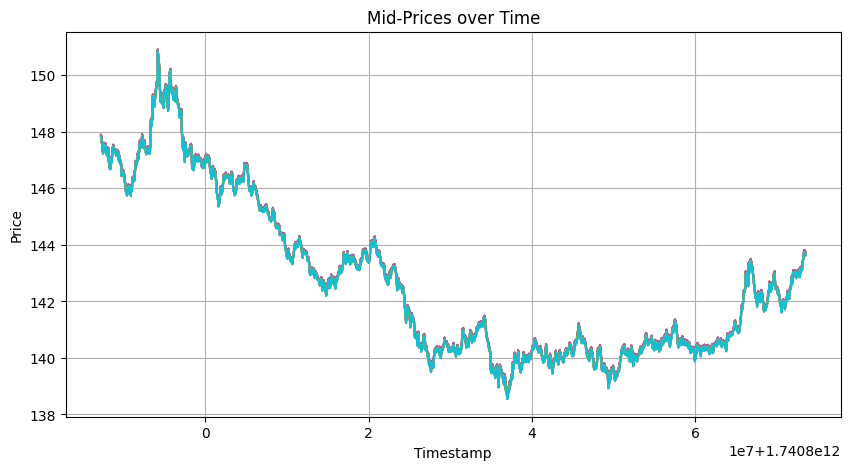

In [3]:
# prompt: write a code to plot the columms starting with ask_1_price till ask_5_price and also bid_1_price till bid_5 price in a same plot against timestamp

ask_price_cols = [col for col in orderbook.columns if col.startswith('ask_') and col.endswith('_price')]
bid_price_cols = [col for col in orderbook.columns if col.startswith('bid_') and col.endswith('_price')]

plt.figure(figsize=(10, 5))

for col in ask_price_cols:
    plt.plot(orderbook['timestamp'], orderbook[col], label=col)

for col in bid_price_cols:
    plt.plot(orderbook['timestamp'], orderbook[col], label=col)

plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Mid-Prices over Time')
# plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import matplotlib.pyplot as plt

# Select bid/ask price columns
ask_price_cols = [col for col in orderbook.columns if col.startswith('ask_') and col.endswith('_price')]
bid_price_cols = [col for col in orderbook.columns if col.startswith('bid_') and col.endswith('_price')]

# Compute true_value (mid price) for each row
orderbook['true_value'] = (
    orderbook[ask_price_cols].min(axis=1) + orderbook[bid_price_cols].max(axis=1)
) / 2

# Plot setup
plt.figure(figsize=(10, 5))

# Plot all bid/ask price levels
for col in ask_price_cols:
    plt.plot(orderbook['timestamp'], orderbook[col], label=col, alpha=1)

for col in bid_price_cols:
    plt.plot(orderbook['timestamp'], orderbook[col], label=col, alpha=1)

# Plot true value line
plt.plot(orderbook['timestamp'], orderbook['true_value'], label='True Value', color='black', linewidth=2)

# Define midpoint for placing region labels
mid_ts = orderbook['timestamp'].iloc[len(orderbook) // 2]

# Shade and label regions
plt.fill_between(orderbook['timestamp'], 137.9, 138.4, color='blue', alpha=0.2)
plt.text(mid_ts, 138.15, 'Region I', fontsize=20, color='blue', ha='center')

plt.fill_between(orderbook['timestamp'], 138.4, 141.5, color='orange', alpha=0.2)
plt.text(mid_ts, 139.9, 'Region II', fontsize=20, color='Orange', ha='center')

plt.fill_between(orderbook['timestamp'], 141.5, 145.8, color='green', alpha=0.2)
plt.text(mid_ts, 143.6, 'Region III', fontsize=20, color='green', ha='center')

plt.fill_between(orderbook['timestamp'], 145.8, 151.0, color='red', alpha=0.2)
plt.text(mid_ts, 148.0, 'Region IV', fontsize=20, color='red', ha='center')

# Final plot styling
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Bid/Ask Prices with True Value and Strategy Bands')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:


import pandas as pd
import numpy as np

class AutomatedMarketMaking:
    def __init__(self, tick_size=0.1, lot_size=2):
        self.tick_size  = tick_size
        self.lot_size   = lot_size
        self.reset_simulator()
        self.prev_best_bid = None
        self.prev_best_ask = None
        self.prev_inventory = 0
        self.prev_bid = None
        self.prev_ask = None
        self.mid_history = []
        # Hyperparameters
        self.window_size =30  # For volatility calculation
        self.gamma = 0.9       # Inventory risk factor
        self.T = 1.0            # Time horizon

    def reset_simulator(self):
        self.inventory  = 0
        self.active_bid = None
        self.active_ask = None
        self.valid_from = None

    def update_quote(self, timestamp, bid_price, ask_price):
        # Post or update your quote at timestamp It takes effect at t+1
        self.active_bid = bid_price
        self.active_ask = ask_price
        self.valid_from = timestamp + 1

    def process_trades(self, timestamp, trades_at_t):
        # Process all public trades at timestamp Returns updated inventory
        if self.valid_from is None or timestamp < self.valid_from:
            return self.inventory

        filled = False

        # sellside fill against your bid
        sells = trades_at_t[trades_at_t.side == 'sell']
        if self.active_bid is not None and not sells.empty:
            if self.active_bid >= sells.price.max():
                self.inventory += self.lot_size
                self.active_bid = None
                filled = True

        # buyside fill against your ask
        buys = trades_at_t[trades_at_t.side == 'buy']
        if self.active_ask is not None and not buys.empty:
            if self.active_ask <= buys.price.min():
                self.inventory -= self.lot_size
                self.active_ask = None
                filled = True

        if filled:
            # deactivate until next update
            self.valid_from = float('inf')

        return self.inventory


    def strategy2(self, ob_df, tr_df, inventory, t):
        # Avoid future data: use only data up to t-1
        ob_up_to = ob_df[ob_df['timestamp'] == t]

        if ob_up_to.empty:
            return self.prev_bid, self.prev_ask

        latest_ob = ob_up_to.iloc[-1]
        best_bid = max(latest_ob['bid_1_price'], latest_ob['bid_2_price'])  # Max of bid1 and bid2
        best_ask = min(latest_ob['ask_1_price'], latest_ob['ask_2_price'])  # Min of ask1 and ask2
        # return best_bid-0.1,best_ask+0.1

        # True value = mid price
        true_value = (best_bid + best_ask) / 2.0

        # Maintain history for momentum calculation
        if not hasattr(self, 'true_value_history'):
            self.true_value_history = []
    
        self.true_value_history.append(true_value)
        # Keep only last 10 values for momentum calculation
        if len(self.true_value_history) > 30:
            self.true_value_history.pop(0)

        self.mid_history.append(true_value)
        if len(self.mid_history) > self.window_size:
            self.mid_history.pop(0)



        # Calculate volatility (std of mid price returns)
        sigma = 0.3
        if len(self.mid_history) >= 30:
            returns = np.diff(self.mid_history) / self.mid_history[:-1]
            sigma = np.std(returns) if len(returns) > 0 else 0.01

        # Reservation price: mid adjusted for inventory risk
        reservation_price = true_value - (inventory * self.gamma * (sigma**2) * self.T)

        # Spread adjustment based on volatility and inventory
        spread = self.tick_size + 2 * self.gamma * (sigma**2) * self.TS
        spread += abs(inventory) * 0.035  # Increased penalty for large positions

        # Calculate base bid/ask around reservation price
        bid_price = reservation_price - spread / 2
        ask_price = reservation_price + spread / 2

        tr_up_to = tr_df[tr_df['timestamp'] == t]
        # Check if there are any 'buy' trades at this timestamp
        if (tr_up_to['side'] == 'buy').any():
            bid_pub = tr_up_to[tr_up_to['side'] == 'buy']['price'].iloc[0]
            ask_pub = ask_price
        if (tr_up_to['side'] == 'sell').any():
            ask_pub = tr_up_to[tr_up_to['side'] == 'sell']['price'].iloc[0]
            bid_pub= bid_price
            



        # Aggressive inventory management
        if inventory >= 16:  # Lowered threshold from 18 
            bid_price = best_bid - 3 * self.tick_size
            ask_price = min(ask_pub - self.tick_size, bid_price + self.tick_size)
        elif inventory <= -16:  # Lowered threshold from -18 
            ask_price = best_ask + 3 * self.tick_size
            bid_price = max(bid_pub + self.tick_size, ask_price - self.tick_size)


        # Round to valid tick sizes
        bid_price = round(bid_price / self.tick_size) * self.tick_size
        ask_price = round(ask_price / self.tick_size) * self.tick_size

        # NEW MOMENTUM-BASED ADJUSTMENT
        # Check if we have enough history (10 timestamps) and momentum condition
        if len(self.true_value_history) == 30:
            init = self.true_value_history[0]
            mid1 = self.true_value_history[10]
            mid3 = self.true_value_history[15]
            mid2 = self.true_value_history[20]
            fin = self.true_value_history[-1]
            
        
            # If price momentum is positive and inventory is non-positive
            if (fin-mid3) > 0 and (mid3-init >0) and inventory < 0:
                bid_price += 0.1
                ask_price += 0.1
            if (fin-mid3) < 0 and ((mid3-init <0) and inventory) > 0:
                bid_price -= 0.1
                ask_price -= 0.1



        # Store for next iteration
        self.prev_inventory = inventory
        self.prev_bid = bid_price
        self.prev_ask = ask_price

        if bid_price >= ask_price:
            bid_price = ask_price - self.tick_size
            if bid_price < 0:
                bid_price = 0.0
                ask_price = self.tick_size



        return bid_price-0.2, ask_price+0.2

    def strategy(self, ob_df, tr_df, inventory, t):
        # Avoid future data: use only data up to t-1
        ob_up_to = ob_df[ob_df['timestamp'] == t]

        if ob_up_to.empty:
            return self.prev_bid, self.prev_ask
  
        latest_ob = ob_up_to.iloc[-1]
        best_bid = min(latest_ob['bid_1_price'], latest_ob['bid_2_price'])  # Max of bid1 and bid2
        best_ask = max(latest_ob['ask_1_price'], latest_ob['ask_2_price'])  # Min of ask1 and ask2
        # return best_bid-0.1,best_ask+0.1

        # True value = mid price
        true_value = (best_bid + best_ask) / 2.0
        
        # if(true_value<150):
        #     return None, None;
        self.mid_history.append(true_value)
        if len(self.mid_history) > self.window_size:
            self.mid_history.pop(0)
            
        
         # Calculate volatility (std of mid price returns)
        sigma = 0.3
        if len(self.mid_history) >= 20:
            returns = np.diff(self.mid_history) / self.mid_history[:-1]
            sigma = np.std(returns) if len(returns) > 0 else 0.01

        # Reservation price: mid adjusted for inventory risk
        reservation_price = true_value - (inventory * self.gamma * (sigma**2) * self.T)
        
        # Spread adjustment based on volatility and inventory
        spread = self.tick_size + 2 * self.gamma * (sigma**2) * self.T
        spread += abs(inventory) * 0.035  # Increased penalty for large positions

        # Calculate base bid/ask around reservation price
        bid_price = reservation_price - spread / 2 
        ask_price = reservation_price + spread / 2 

        # Aggressive inventory management
        if inventory >= 16:  # Lowered threshold from 18 to 16
            bid_price = best_bid - 1 * self.tick_size
            ask_price = max(best_ask - self.tick_size, bid_price + self.tick_size)
        elif inventory <= -16:  # Lowered threshold from -18 to -16
            ask_price = best_ask + 1 * self.tick_size
            bid_price = max(best_bid + self.tick_size, ask_price - self.tick_size)
        
        
        # if(true_value>147.0):
        #      return bid_price-0.1, ask_price+0.5
        # if(true_value<139.5):
        #      return bid_price+0.1, ask_price+0.1
        # else :
        #     return best_bid-0.9,best_ask+0.9 ;
        
        if(true_value>=135 and true_value<=141.5):
            ask_price+=0.3
        elif(true_value>=141.5 and true_value<=145.8):
            bid_price-=0.3; ask_price+=0.3
        elif(true_value<=135.0):
            bid_price+=0.1;ask_price+=0.5
        elif(true_value>=147.8):
            bid_price-=0.2
        
            

        # Ensure bid < ask and handle edge cases
        if bid_price >= ask_price:
            bid_price = ask_price - self.tick_size
            if bid_price < 0:
                bid_price = 0.0
                ask_price = self.tick_size

        # Round to valid tick sizes
        bid_price = round(bid_price / self.tick_size) * self.tick_size
        ask_price = round(ask_price / self.tick_size) * self.tick_size

        # Store for next iteration
        self.prev_inventory = inventory
        self.prev_bid = bid_price
        self.prev_ask = ask_price
        
        


        return bid_price-0.2, ask_price+0.2


    def run(self, ob_df, tr_df):
        self.reset_simulator()
        quotes = []

        all_ts = sorted(ob_df.timestamp.unique())
        for t in all_ts:
            trades_t = tr_df[tr_df.timestamp == t]
            inv      = self.process_trades(t, trades_t)

            bid, ask = self.strategy(ob_df, tr_df, inv, t)
            if( bid==None  or ask==None):
                continue

            self.update_quote(t, bid, ask)

            quotes.append({
                'timestamp': t,
                'bid_price': bid,
                'ask_price': ask
            })

        return pd.DataFrame(quotes)



import pandas as pd
import numpy as np
from collections import deque

class AMMWithPnL(AutomatedMarketMaking):
    def __init__(self, tick_size=0.1, lot_size=2):
        super().__init__(tick_size, lot_size)
        self.reset_simulator()
        self.TS=1

    def reset_simulator(self):
        super().reset_simulator()
        self.cash = 0.0
        self.realized_pnl = 0.0
        self.unrealized_pnl = 0.0
        self.penalties = 0.0
        self.average_cost = 0.0
        self.trade_history = deque()
        self.inventory_history = []
        self.pnl_history = []

    def process_trades(self, timestamp, trades_at_t):
        if self.valid_from is None or timestamp < self.valid_from:
            return self.inventory

        # Process trades
        for _, trade in trades_at_t.iterrows():
            if trade.side == 'sell' and self.active_bid is not None and self.active_bid >= trade.price:
                # Buy at trade price
                cost = trade.price * self.lot_size
                self.cash -= cost
                self.trade_history.append(('buy', trade.price, self.lot_size))

                # Update average cost
                prev_value = self.average_cost * self.inventory
                self.inventory += self.lot_size
                self.average_cost = (prev_value + cost) / self.inventory if self.inventory else 0

                # Deactivate bid
                self.active_bid = None

            elif trade.side == 'buy' and self.active_ask is not None and self.active_ask <= trade.price:
                # Sell at trade price
                revenue = trade.price * self.lot_size
                self.cash += revenue
                self.trade_history.append(('sell', trade.price, self.lot_size))

                # Update average cost
                self.inventory -= self.lot_size
                if self.inventory == 0:
                    self.average_cost = 0

                # Deactivate ask
                self.active_ask = None

        return self.inventory

    def calculate_pnl(self, mid_price):
        # Calculate unrealized PnL
        if self.inventory != 0:
            self.unrealized_pnl = self.inventory * (mid_price - self.average_cost)
        else:
            self.unrealized_pnl = 0

        # Check for penalties
        penalty = 0
        if self.active_bid is not None and self.active_ask is not None:
            if self.active_bid >= self.active_ask:
                penalty += 1000  # Large penalty for crossed spread

        if abs(self.inventory) > 20:
            penalty += 500 * (abs(self.inventory) - 20)  # Penalty per excess unit

        self.penalties += penalty

        # Total PnL
        total_pnl = self.cash + self.unrealized_pnl - self.penalties

        return {
            'timestamp': self.current_time,
            'realized_pnl': self.cash,
            'unrealized_pnl': self.unrealized_pnl,
            'penalties': self.penalties,
            'total_pnl': total_pnl,
            'inventory': self.inventory
        }

    def run(self, ob_df, tr_df):
        self.reset_simulator()
        quotes = []
        pnl_records = []

        all_ts = sorted(ob_df.timestamp.unique())
        for t in all_ts:
            self.current_time = t
            trades_t = tr_df[tr_df.timestamp == t]
            self.inventory = self.process_trades(t, trades_t)

            # Get current order book
            ob_at_t = ob_df[ob_df.timestamp == t].iloc[0]

            # Calculate volume-weighted mid price
            bid_sum = sum(ob_at_t[f'bid_{i}_price'] * ob_at_t[f'bid_{i}_size'] for i in range(1, 3))
            ask_sum = sum(ob_at_t[f'ask_{i}_price'] * ob_at_t[f'ask_{i}_size'] for i in range(1, 3))
            total_bid_size = sum(ob_at_t[f'bid_{i}_size'] for i in range(1,3))
            total_ask_size = sum(ob_at_t[f'ask_{i}_size'] for i in range(1, 3))

            if total_bid_size > 0 and total_ask_size > 0:
                weighted_bid = bid_sum / total_bid_size
                weighted_ask = ask_sum / total_ask_size
                true_value = (weighted_bid + weighted_ask) / 2
            else:
                true_value = (ob_at_t['bid_price_1'] + ob_at_t['ask_price_1']) / 2

            # Calculate PnL
            pnl_record = self.calculate_pnl(true_value)
            pnl_records.append(pnl_record)

            # Generate quotes
            bid, ask = self.strategy(ob_df, tr_df, self.inventory, t)
            if( bid==None or ask== None):
                continue
            self.update_quote(t, bid, ask)

            quotes.append({
                'timestamp': t,
                'bid_price': bid,
                'ask_price': ask
            })

        return pd.DataFrame(quotes), pd.DataFrame(pnl_records)


if __name__ == "__main__":
    ob_obj = pd.read_csv('/kaggle/input/goldmanq2/orderbook_train.csv')
    tr_obj = pd.read_csv('/kaggle/input/goldmanq2/public_trades_train.csv')

    #pick top 3k timestamps
    ob_obj = ob_obj.head(3000);
    tr_obj = tr_obj.head(3000);

    amm = AMMWithPnL(tick_size=0.1, lot_size=2)
    quotes_df, pnl_df = amm.run(ob_obj, tr_obj)

    quotes_df.to_csv('submission.csv', index=False)
    pnl_df.to_csv('pnl_history_2.csv', index=False)




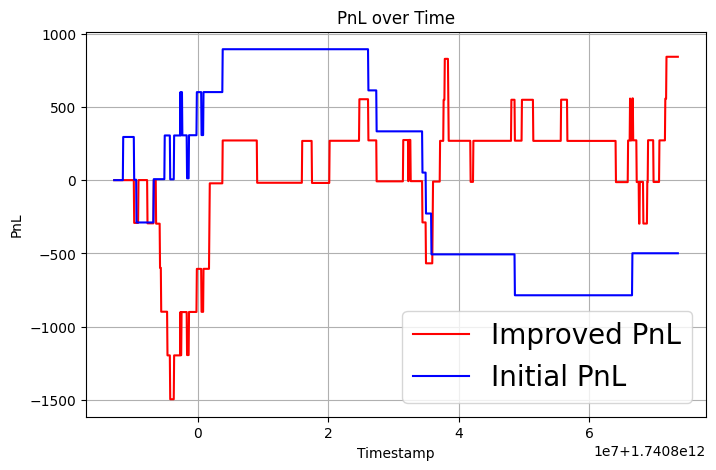

In [41]:
# prompt: edit below code to plot realised unrealised pnl
import matplotlib.pyplot as plt
# Plot PnL components
plt.figure(figsize=(8, 5))

pnl_df = pd.read_csv('/kaggle/working/pnl_history.csv')
pnl_df_2 = pd.read_csv('/kaggle/working/pnl_history_2.csv')

plt.plot(pnl_df['timestamp'], pnl_df['realized_pnl'], label='Improved PnL' , color = 'red')
plt.plot(pnl_df_2['timestamp'], pnl_df_2['realized_pnl'], label='Initial PnL' , color= 'blue')
# plt.plot(pnl_df['timestamp'], pnl_df['unrealized_pnl'], label='Unrealized PnL')
# plt.plot(pnl_df['timestamp'], pnl_df['total_pnl'], label='Total PnL', linestyle='--')

plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.title('PnL over Time')
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

# # Plot Inventory over time
# plt.figure(figsize=(15, 5))
# plt.plot(pnl_df['timestamp'], pnl_df['inventory'], label='Inventory', color='purple')
# plt.xlabel('Timestamp')
# plt.ylabel('Inventory')
# plt.title('Inventory over Time')
# plt.legend()
# plt.grid(True)
# plt.show()


# Question 3 :  KnockOut Option Pricing using MonteCarlo

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.linalg import cholesky
from scipy.optimize import brentq


def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(price, S, K, T, r):
    def f(sigma):
        return black_scholes_call(S, K, T, r, sigma) - price
    try:
        return brentq(f, 0.001,5 )  # IV between 0.1% and 500%
    except ValueError:
        return np.sqrt(2*np.pi/T) * price/S

# Parse calibration data
calib_data = '''CalibIdx,Stock,Type,Strike,Maturity,Price
1,DTC,Call,50,1y,52.44
2,DTC,Call,50,2y,54.77
3,DTC,Call,50,5y,61.23
4,DTC,Call,75,1y,28.97
5,DTC,Call,75,2y,33.04
6,DTC,Call,75,5y,43.47
7,DTC,Call,100,1y,10.45
8,DTC,Call,100,2y,16.13
9,DTC,Call,100,5y,29.14
10,DTC,Call,125,1y,2.32
11,DTC,Call,125,2y,6.54
12,DTC,Call,125,5y,18.82
13,DTC,Call,150,1y,0.36
14,DTC,Call,150,2y,2.34
15,DTC,Call,150,5y,11.89
16,DFC,Call,50,1y,52.45
17,DFC,Call,50,2y,54.9
18,DFC,Call,50,5y,61.87
19,DFC,Call,75,1y,29.11
20,DFC,Call,75,2y,33.34
21,DFC,Call,75,5y,43.99
22,DFC,Call,100,1y,10.45
23,DFC,Call,100,2y,16.13
24,DFC,Call,100,5y,29.14
25,DFC,Call,125,1y,2.8
26,DFC,Call,125,2y,7.39
27,DFC,Call,125,5y,20.15
28,DFC,Call,150,1y,1.26
29,DFC,Call,150,2y,4.94
30,DFC,Call,150,5y,17.46
31,DEC,Call,50,1y,52.44
32,DEC,Call,50,2y,54.8
33,DEC,Call,50,5y,61.42
34,DEC,Call,75,1y,29.08
35,DEC,Call,75,2y,33.28
36,DEC,Call,75,5y,43.88
37,DEC,Call,100,1y,10.45
38,DEC,Call,100,2y,16.13
39,DEC,Call,100,5y,29.14
40,DEC,Call,125,1y,1.96
41,DEC,Call,125,2y,5.87
42,DEC,Call,125,5y,17.74
43,DEC,Call,150,1y,0.16
44,DEC,Call,150,2y,1.49
45,DEC,Call,150,5y,9.7'''

data_calib = pd.read_csv(pd.io.common.StringIO(calib_data))
data_calib['Maturity'] = data_calib['Maturity'].str.replace('y', '').astype(float)
data_calib['iv'] = data_calib.apply(lambda row: implied_volatility(row['Price'], 100.0, row['Strike'], row['Maturity'], 0.05), axis=1)

data_calib

,CalibIdx,Stock,Type,Strike,Maturity,Price,iv
0,1,DTC,Call,50,1.0,52.44,0.220506
1,2,DTC,Call,50,2.0,54.77,0.196690
2,3,DTC,Call,50,5.0,61.23,0.199557
3,4,DTC,Call,75,1.0,28.97,0.199456
4,5,DTC,Call,75,2.0,33.04,0.199894
5,6,DTC,Call,75,5.0,43.47,0.200106
6,7,DTC,Call,100,1.0,10.45,0.199984
7,8,DTC,Call,100,2.0,16.13,0.200065
8,9,DTC,Call,100,5.0,29.14,0.200021
9,10,DTC,Call,125,1.0,2.32,0.199856


## local volatility matrix ( 5 X 3 )

In [2]:
# Create volatility matrices for each stock
stocks = ['DTC', 'DFC', 'DEC']
vol_matrices = {}
strike_levels = [50, 75, 100, 125, 150]
maturity_levels = [1.0, 2.0, 5.0]

for stock in stocks:
    df_stock = data_calib[data_calib['Stock'] == stock]
    vol_matrix = df_stock.pivot(index='Strike', columns='Maturity', values='iv').reindex(index=strike_levels, columns=maturity_levels)
    vol_matrices[stock] = vol_matrix.values  
vol_matrices

{'DTC': array([[0.22050559, 0.19669028, 0.19955725],
        [0.19945571, 0.19989356, 0.20010562],
        [0.19998445, 0.20006452, 0.20002102],
        [0.19985632, 0.20000387, 0.20005671],
        [0.20003787, 0.2000881 , 0.19991722]]),
 'DFC': array([[0.26074518, 0.26195559, 0.26239836],
        [0.21519673, 0.21549244, 0.21542303],
        [0.19998445, 0.20006452, 0.20002102],
        [0.21556467, 0.21563958, 0.21560721],
        [0.26232779, 0.2624594 , 0.26247785]]),
 'DEC': array([[0.22050559, 0.2240609 , 0.22482401],
        [0.21207388, 0.21252633, 0.21229914],
        [0.19998445, 0.20006452, 0.20002102],
        [0.18745271, 0.18753344, 0.18747065],
        [0.17455283, 0.17469373, 0.17503793]])}

In [3]:
# Correlation matrix and Cholesky decomposition
corr_matrix = np.array([[1.0, 0.75, 0.5],
                        [0.75, 1.0, 0.25],
                        [0.5, 0.25, 1.0]])
L = cholesky(corr_matrix, lower=True)
    
# L = np.linalg.cholesky(corr_matrix)
L


array([[ 1.        ,  0.        ,  0.        ],
       [ 0.75      ,  0.66143783,  0.        ],
       [ 0.5       , -0.18898224,  0.84515425]])


Pricing Put option:
Maturity: 2.0 years | Strike: 100 | Barrier: 150
Simulation: 2000 paths, 200 time steps
Step 1/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 6/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 11/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 16/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 21/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 26/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 31/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 36/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 41/200: Knockouts: 0 (0.0%) | Avg volatility: 0.20
Step 46/200: Knockouts: 1 (0.1%) | Avg volatility: 0.20
Step 51/200: Knockouts: 1 (0.1%) | Avg volatility: 0.20
Step 56/200: Knockouts: 1 (0.1%) | Avg volatility: 0.20
Step 61/200: Knockouts: 3 (0.1%) | Avg volatility: 0.20
Step 66/200: Knockouts: 7 (0.4%) | Avg volatility: 0.20
Step 71/200: Knockouts: 8 (0.4%) | Avg volatility: 0.20
Step 76/200: Knockouts: 13 (0.7%) | Avg volatility: 0

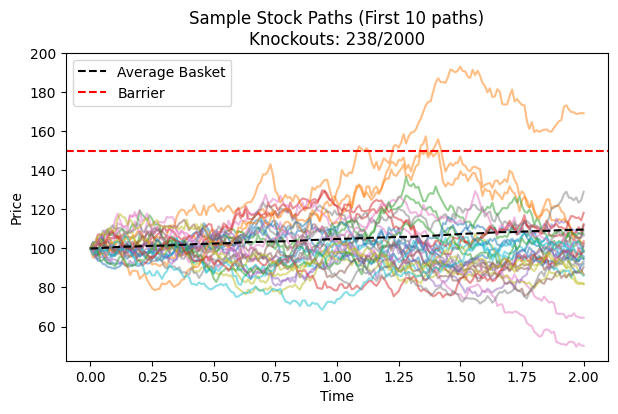

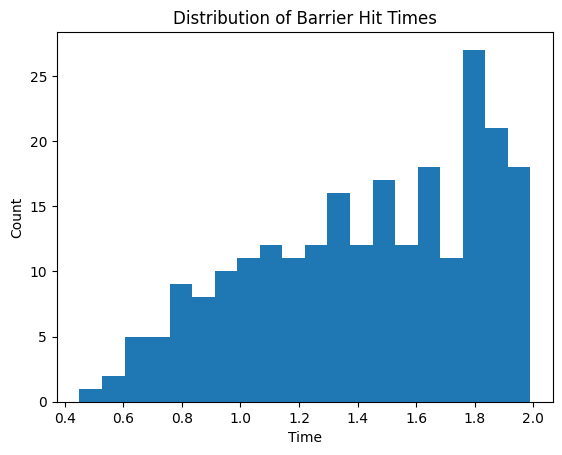

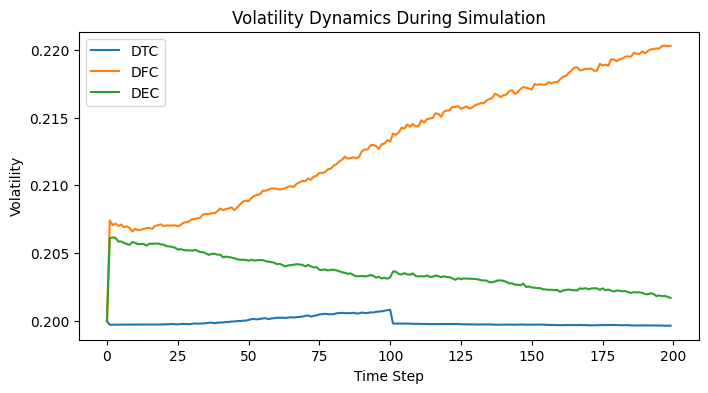


Simulation Statistics:
Final price: 5.10
Knockout percentage: 11.9%
Effective paths: 1762
Average final basket: 109.64
Payoff stats: Mean=5.63, Max=55.34

Final calculated price: 5.10


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def price_option(T, B, K, option_type, n_paths=2000, steps_per_year=50, verbose=False):
    
    # Simulation parameters
    r = 0.05  # Risk-free rate
    dt = 1.0 / steps_per_year
    n_steps = int(T * steps_per_year)
    time_grid = np.linspace(0, T, n_steps + 1)
    
    if verbose:
        print(f"\nPricing {option_type} option:")
        print(f"Maturity: {T} years | Strike: {K} | Barrier: {B}")
        print(f"Simulation: {n_paths} paths, {n_steps} time steps")

    # Initialize paths for 3 stocks
    paths = np.ones((3, n_steps + 1, n_paths)) * 100.0  # Shape: (stocks, time, paths)
    knocked_out = np.zeros(n_paths, dtype=bool)
    barrier_hit_times = []
    
    stocks = ['DTC', 'DFC', 'DEC']
    

    # Store volatility diagnostics
    vol_history = {stock: [] for stock in stocks}

    # Main simulation loop
    for i in range(n_steps):
        current_time = time_grid[i]
        
        if current_time <= 1.0: # I year maturity
            col_idx = 0
        elif current_time <= 2.0: # 2 year maturity
            col_idx = 1
        else:
            col_idx = 2 # 5 year maturity

        
        # Generate correlated random numbers
        z = np.random.normal(size=(n_paths, 3))

        corr_z = z @ L.T  # Correlated normal variables
        
        # print(corr_z.shape)
        # Update each stock's path
        for stock_idx in range(3):
            
            S_prev = paths[stock_idx, i]
            # print('Sprev: ' , S_prev)
            
            # Select volatility based on current price and strike levels
            strike_indices = np.digitize(S_prev, bins=strike_levels, right=False) - 1
            # print('Indices where Spot price is just above Strike Price:')
            # print(strike_indices)
            strike_indices = np.clip(strike_indices, 0, len(strike_levels)-1)
            sigma = vol_matrices[stocks[stock_idx]][strike_indices, col_idx]
            # print('mapped volatility based on K and T')
            # print(sigma)
            
            # Store volatility information for diagnostics
            vol_history[stocks[stock_idx]].append(sigma.mean())
            
            
            # Euler-Maruyama discretization
            drift = r * S_prev * dt
            diffusion = sigma * S_prev * np.sqrt(dt) * corr_z[:, stock_idx]
            paths[stock_idx, i+1] = S_prev + drift + diffusion

        # Calculate basket value and check barrier condition
        basket = np.mean(paths[:, i+1], axis=0)
        new_knockouts = (basket >= B) & ~knocked_out
        barrier_hit_times.extend([current_time]*np.sum(new_knockouts))
        knocked_out |= new_knockouts

        if verbose and i % 5 == 0:
            print(f"Step {i+1}/{n_steps}: "
                  f"Knockouts: {knocked_out.sum()} ({knocked_out.sum()/n_paths:.1%}) | "
                  f"Avg volatility: {np.mean([v[-1] for v in vol_history.values()]):.2f}")

    # Final payoff calculation
    final_basket = np.mean(paths[:, -1], axis=0)
    print(paths[:, -1])
    if option_type == 'Call':
        payoff = np.maximum(final_basket - K, 0)
    else:
        payoff = np.maximum(K - final_basket, 0)
    
    payoff[knocked_out] = 0
    price = np.exp(-r * T) * np.mean(payoff)
    
    # Visualization
    if verbose:
        # Plot sample paths
        plt.figure(figsize=(7, 4))
        for j in range(3):
            plt.plot(time_grid, paths[j, :, :10], alpha=0.5)
        plt.plot(time_grid, np.mean(paths, axis=(0,2)), 'k--', label='Average Basket')
        plt.axhline(B, color='r', linestyle='--', label='Barrier')
        plt.title(f"Sample Stock Paths (First 10 paths)\nKnockouts: {knocked_out.sum()}/{n_paths}")
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # Plot barrier hit times
        if barrier_hit_times:
            plt.hist(barrier_hit_times, bins=20)
            plt.title('Distribution of Barrier Hit Times')
            plt.xlabel('Time')
            plt.ylabel('Count')
            plt.show()

        # Plot volatility history
        plt.figure(figsize=(8, 4))
        for stock, vols in vol_history.items():
            plt.plot(vols, label=stock)
        plt.title('Volatility Dynamics During Simulation')
        plt.xlabel('Time Step')
        plt.ylabel('Volatility')
        plt.legend()
        plt.show()

        # Print summary statistics
        print("\nSimulation Statistics:")
        print(f"Final price: {price:.2f}")
        print(f"Knockout percentage: {knocked_out.mean():.1%}")
        print(f"Effective paths: {n_paths - knocked_out.sum()}")
        print(f"Average final basket: {final_basket.mean():.2f}")
        print(f"Payoff stats: Mean={payoff.mean():.2f}, Max={payoff.max():.2f}")

    return max(price, 0)

# Example usage with diagnostics
if __name__ == "__main__":
    # Test one option with verbose output
    test_price = price_option(
        T=2.0,
        B=150,
        K=100,
        option_type='Put',
        n_paths=2000,
        steps_per_year=100,
        verbose=True
    )
    print(f"\nFinal calculated price: {test_price:.2f}")
